# Numerical Integration of the FTE

Formal transfer equation:
$$ \frac{dI(s)}{ds} = \alpha(s) (S(s) - I(s)) $$

Ignoring scattering, we have $S(s) = B(s)$. Assuming a Gaussian form for $B(s)$:
$$ B(s) = B_0 + (B_1 - B_0) \exp\left(-\frac{s^2}{2w^2}\right) $$

and a simple box function for the extinction coefficient:
` alpha = A if abs(s) <= L else 0`

* At $s < -L$, $I = I_{in}$.
* Want to compute $I_{out}$ at $s > L$.

In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# set default parameters
L = 3
B0 = 1
B1 = 3
w = 1
I_init = 0
A = 1

# setup grid within -L to L with N = 100.
N = 100
h = 2 * L/N

s = np.linspace(-L, L, N)
I = np.zeros(N)
I[0] = I_init

## Question 1
Total optical depth is [given by](https://en.wikipedia.org/wiki/Optical_depth_(astrophysics))

$$ \tau = \int_{-L}^{L} \alpha dz $$

which gives $\tau = 2A L = 6$.

Note that we have the following given **parameters**:
* L = 3
* A = 1

## Question 2

Use simple forward Euler to get $I(s)$ at all grid points.

In [5]:
# Define some helper functions

def f(alpha, source, intensity):
    """
    RHS of the FTE
    """
    return alpha * (source  - intensity)

def B(B0, B1, s, w):
    """
    Gaussian Planck function
    """
    return B0 + (B1 - B0) * np.exp(-1/2 * s**2/w**2)

def alpha(s, A, L):
    """
    Extinction coefficient
    """
    return A if abs(s) <= L else 0

In [6]:
# now let's iterate using explicit Euler
# I[0] = I_init

for i in range(1, N):
    I[i] = h * f(alpha(s[i-1], A, L), B(B0, B1, s[i-1], w), I[i-1]) + I[i-1]

Text(0.5,1,'Numerical solution with the forward Euler method')

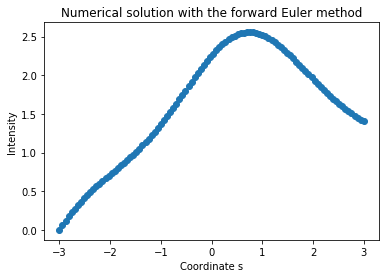

In [7]:
plt.plot(s, I, 'o')
plt.xlabel("Coordinate s")
plt.ylabel("Intensity")
plt.title("Numerical solution with the forward Euler method")

## Question 3

Now set **A = 10**. Note that this affects only the extinction coefficient alpha.

Text(0.5,1,'Numerical solution with the forward Euler method')

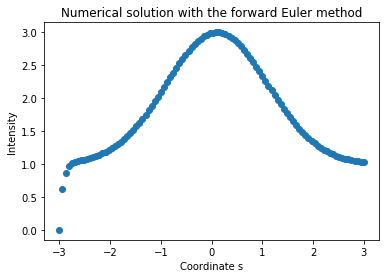

In [8]:
A = 10

# reset the intensity values
I = np.zeros(N)
I[0] = I_init

# explicit euler
for i in range(1, N):
    I[i] = h * f(alpha(s[i-1], A, L), B(B0, B1, s[i-1], w), I[i-1]) + I[i-1]
    
plt.plot(s, I, 'o')
plt.xlabel("Coordinate s")
plt.ylabel("Intensity")
plt.title("Numerical solution with the forward Euler method")

## Question 4

Now we try again with **A = 100**. We get now numerical instability. One needs a disproportionately small step size to tackle this.

Text(0.5,1,'Numerical solution with the forward Euler method')

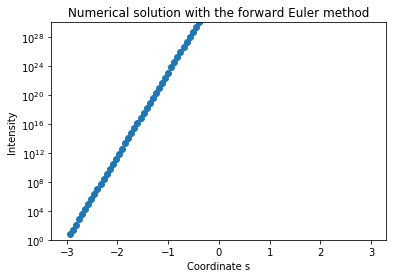

In [9]:
A = 100

# reset the intensity values
I = np.zeros(N)
I[0] = I_init

for i in range(1, N):
    I[i] = h * f(alpha(s[i-1], A, L), B(B0, B1, s[i-1], w), I[i-1]) + I[i-1]
    
plt.plot(s, np.abs(I), 'o')
plt.ylim(1., 1e30)
plt.yscale("Log")
plt.xlabel("Coordinate s")
plt.ylabel("Intensity")
plt.title("Numerical solution with the forward Euler method")

## Question 5, 6, and 7

Since we have a uniform grid, the optical depth for each grid point is
$$ \tau = h \alpha = h A$$
because the extinction coefficient is constant within the box. Now, the exact integral is
$$I_{next} = I_{prev}  e^{-\tau} + (1 - e^{-\tau})  B$$
assuming $B$ is constant throughout the cell and we simply use the average between two neighbouring grid points. This method gives reasonable emerging intensity $I_{out}$ and is called *first-order integration*.

In [13]:
A = 1
tau = h * A

# reset the intensity values
I = np.zeros(N)
I[0] = I_init

for i in range(1, N):
    B_avg = B(B0, B1, (s[i] + s[i-1])/2, w) # can change this to use the average between two neighbouring grid points
    I[i] = I[i-1] * np.exp(-tau) + (1 - np.exp(-tau)) * B_avg

Text(0.5,1,'Piecewise Analytic Solution for A = 1')

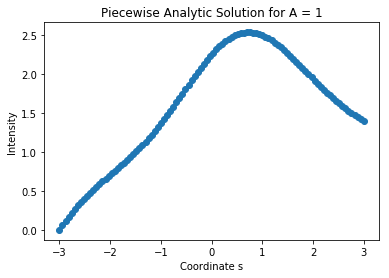

In [15]:
plt.plot(s, I, 'o')
plt.xlabel("Coordinate s")
plt.ylabel("Intensity")
plt.title("Piecewise Analytic Solution for A = 1")

Text(0.5,1,'Piecewise Analytic Solution for A = 10')

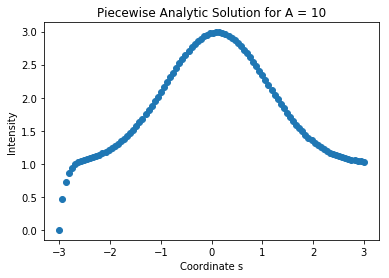

In [19]:
A = 10
tau = h * A

# reset the intensity values
I = np.zeros(N)
I[0] = I_init

for i in range(1, N):
    B_avg = B(B0, B1, (s[i] + s[i-1])/2, w) # can change this to use the average between two neighbouring grid points
    I[i] = I[i-1] * np.exp(-tau) + (1 - np.exp(-tau)) * B_avg
    
plt.plot(s, I, 'o')
plt.xlabel("Coordinate s")
plt.ylabel("Intensity")
plt.title("Piecewise Analytic Solution for A = " + str(A))

Text(0.5,1,'Piecewise Analytic Solution for A = 100')

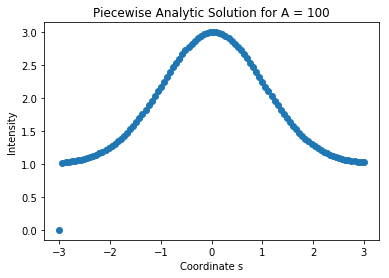

In [20]:
A = 100
tau = h * A

# reset the intensity values
I = np.zeros(N)
I[0] = I_init

for i in range(1, N):
    B_avg = B(B0, B1, (s[i] + s[i-1])/2, w) # can change this to use the average between two neighbouring grid points
    I[i] = I[i-1] * np.exp(-tau) + (1 - np.exp(-tau)) * B_avg
    
plt.plot(s, I, 'o')
plt.xlabel("Coordinate s")
plt.ylabel("Intensity")
plt.title("Piecewise Analytic Solution for A = " + str(A))

## Question 8, 9, 10

However, first order integration does not account for radiative diffusion and can produce wrong results for scattering problems in the regimes of high optical depth. To tackle this problem, let's consider linear interpolation of $B$ within a cell, using optical depth as the coordinate: $ d\tau = \alpha(s) ds$ such that the FTE becomes

$$ \frac{dI(\tau)}{d\tau} = S(\tau) - I(\tau) $$

with the interpolated values for the source:

$$ S(\tau) = \left(1 - \frac{\tau}{\Delta\tau}\right) S_i + \left(\frac{\tau}{\Delta\tau}\right) S_{i+1} $$

where $\Delta\tau$ is the grid spacing. The iterative formula for $I$ won't be typed here but directly implemented below.

Text(0.5,1,'OK87 for A = 100')

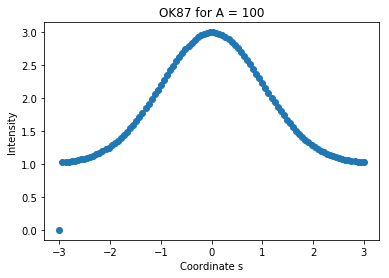

In [21]:
A = 100
tau = h * A

# reset the intensity values
I = np.zeros(N)
I[0] = I_init

for i in range(1, N):
    coef1 = (1 - (1 + tau) * np.exp(-tau))/tau
    coef2 = (tau - 1 + np.exp(-tau))/tau
    I[i] = I[i-1] * np.exp(-tau) + coef1 * B(B0, B1, s[i-1], w) + coef2 * B(B0, B1, s[i], w)
    
plt.plot(s, I, 'o')
plt.xlabel("Coordinate s")
plt.ylabel("Intensity")
plt.title("OK87 for A = " + str(A))